# Activation Patching

In [1]:
import torch, transformer_lens, itertools
from functools import partial
torch.set_grad_enabled(False)

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

from tqdm import tqdm
from measureLM import helpers, measuring, synth_data, patching, visualizing

## Data and Model

In [2]:
model_name = "gpt2-medium"
model = measuring.load_model(model_name=model_name, device="mps")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  mps


In [3]:
scales = ["positive", "negative"]
scale_idx = measuring.get_logit_indices(scales, model)

df = synth_data.load_synth_data(n=4, seed=12)
context_pairs = synth_data.construct_bias_context_pairs(df, pair_type="context")
context_pairs

pair_type: context --> 8 data points


[('Donald Trump loves Joe Biden. The relationship between Donald Trump and Joe Biden is',
  'The relationship between Donald Trump and Joe Biden is'),
 ('Donald Trump hates Joe Biden. The relationship between Donald Trump and Joe Biden is',
  'The relationship between Donald Trump and Joe Biden is'),
 ('Bilbo Baggins loves Sauron. The relationship between Bilbo Baggins and Sauron is',
  'The relationship between Bilbo Baggins and Sauron is'),
 ('Bilbo Baggins hates Sauron. The relationship between Bilbo Baggins and Sauron is',
  'The relationship between Bilbo Baggins and Sauron is'),
 ('Gauls loves Rome. The relationship between Gauls and Rome is',
  'The relationship between Gauls and Rome is'),
 ('Gauls hates Rome. The relationship between Gauls and Rome is',
  'The relationship between Gauls and Rome is'),
 ('Shrek loves Donkey. The relationship between Shrek and Donkey is',
  'The relationship between Shrek and Donkey is'),
 ('Shrek hates Donkey. The relationship between Shrek and

## Get Patches for Bias and Context

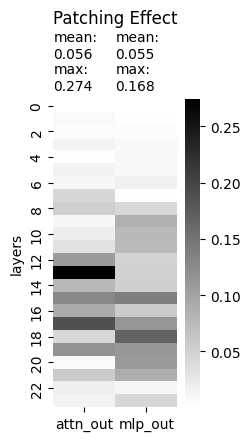

In [4]:
new_prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
old_prompt = ["Harry Potter absolutely hates Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
#new_prompt = ["Harry absolutely loves Ron. The relationship between Harry Potter and Ronald Weasley is"]
#new_prompt = ["The relationship between Demorats and Republicans is"]
#new_prompt = ["Democrats like Republicans. The relationship between Democrats and Republicans is"]
#new_prompt = ["The relationship between Democrats and Republicans is"]
#old_prompt = ["The relationship between Harry and Ron is"]

old_logits, old_activs = measuring.prompt_with_cache(model,old_prompt,logit_idx=scale_idx,norm=False)
new_logits, new_activs = measuring.prompt_with_cache(model,new_prompt,logit_idx=scale_idx,norm=False)

vector_scale, vector_dir = patching.patch_activs(model, old_logits, new_logits, new_activs, old_prompt, scale_idx)
visualizing.plot_heatmap(vector_scale.cpu().numpy(), cmap="binary")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


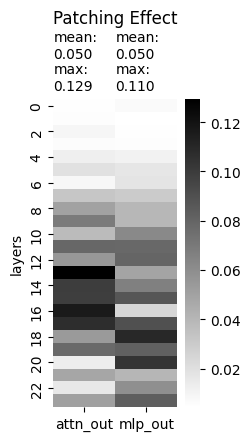

In [5]:
context_scale, context_dir = patching.run_patching_loop(model, context_pairs, scale_idx)
visualizing.plot_heatmap(context_scale.mean(0).cpu().numpy(), cmap="binary")

## Apply Patches

### Before Patching

In [6]:
prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
prompt = ["Harry Potter literally detests Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
prompt = ["Harry Potter loves Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]

logits, activs = measuring.prompt_with_cache(model,prompt,logit_idx=scale_idx,norm=True)
scale_v = logits[..., 0]
scale_v

/Users/niklasstoehr/Code/measureLM/measureLM_venv/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  nonzero_finite_vals = torch.masked_select(


tensor([0.5889], device='mps:0')

### After Patching

In [14]:
context_dir_scale = patching.prepare_dir_scale_patch(context_dir,context_scale)

context_patch_logits = patching.control_bias_context(model, prompt, context_dir_scale, alpha=100)
context_patch_logits = patching.measuring.select_logits(context_patch_logits[:,-1,:], scale_idx, norm=True)

context_scale_v = context_patch_logits[..., 0]
context_scale_v

tensor(0.4855, device='mps:0')

In [9]:
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from measureLM import helpers
from matplotlib.lines import Line2D

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


def collect_alpha_patching(model, prompt, context_dir_scale, alpha_range = [-1, 3.0], alpha_steps=4):
    
    pos_range = np.logspace(alpha_range[0], alpha_range[1], num=alpha_steps)
    neg_range = -pos_range[::-1]
    alpha_x_range = list(np.stack((neg_range, pos_range), axis=0).reshape(-1))
    alpha_x_range.insert(alpha_steps, 0)
    context_scale_values = []
    
    for alpha_x in tqdm(alpha_x_range):
        context_patch_logits = patching.control_bias_context(model, prompt, context_dir_scale, alpha=alpha_x)
        context_patch_logits = patching.measuring.select_logits(context_patch_logits[:,-1,:], scale_idx, norm=True)
        context_scale_v = context_patch_logits[..., 0]
        context_scale_values.append(context_scale_v.item())
    return (alpha_x_range, context_scale_values)

no_context_prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
neg_context_prompt = ["Harry Potter hates Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
pos_context_prompt = ["Harry Potter loves Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]

no_context_alpha = collect_alpha_patching(model, no_context_prompt, context_dir_scale)
neg_context_alpha = collect_alpha_patching(model, neg_context_prompt, context_dir_scale)
pos_context_alpha = collect_alpha_patching(model, pos_context_prompt, context_dir_scale)

100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


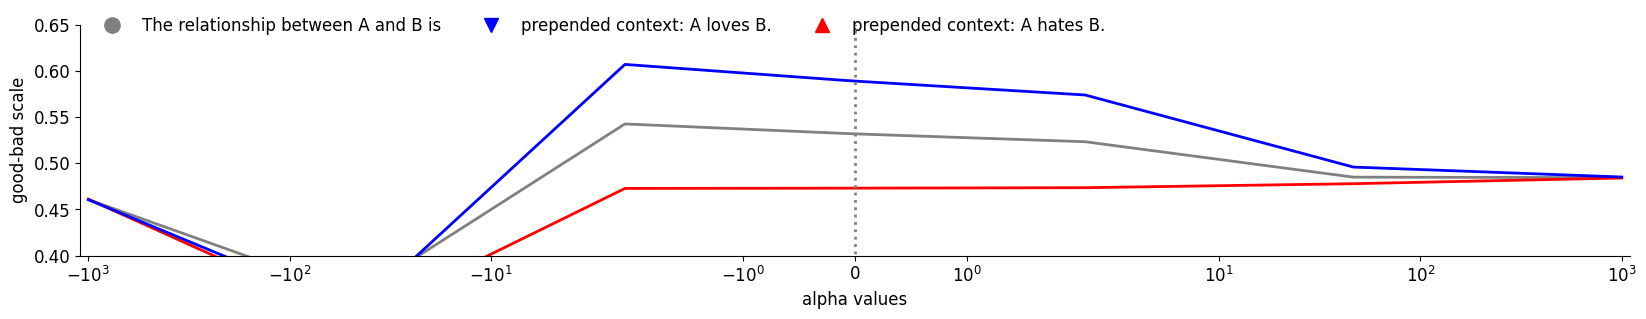

In [10]:
def alpha_plot(no_context_alpha, pos_context_alpha, neg_context_alpha):

    fig, ax = plt.subplots(1, 1, figsize=(20, 3), gridspec_kw={'hspace': 0.4})    
    labelsize = 12
    linewidth = 2

    ax.plot(*no_context_alpha, color="grey", linewidth=linewidth, linestyle="-")
    ax.plot(*neg_context_alpha, color="red", linewidth=linewidth)
    ax.plot(*pos_context_alpha, color="blue", linewidth=linewidth)
    ax.vlines(0, 0, 1, colors="grey", linestyles=':', linewidth=linewidth)
    ax.set_ylim(0.4,0.65)

    ax.set_xlabel('alpha values', fontsize=labelsize)
    ax.set_ylabel('good-bad scale', fontsize=labelsize)

    ax.tick_params(axis='both', which='major', labelsize=labelsize)
    ax.set_xscale('symlog')

    no_context = Line2D([0], [0], label='The relationship between A and B is', marker='.', markersize=22,color='grey', linestyle='')
    pos_context = Line2D([0], [0], label='prepended context: A loves B.', marker='v', markersize=10, color='blue',linestyle='')
    neg_context = Line2D([0], [0], label='prepended context: A hates B.', marker='^', markersize=10, color='red',linestyle='')

    # add manual symbols to auto legend
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.extend([no_context, pos_context, neg_context])
    plt.legend(handles=handles, ncol=len(handles), prop={'size': labelsize}, facecolor='white', framealpha=0,loc='upper left', bbox_to_anchor=(0.0, 1.1))
    plt.show()
    
alpha_plot(no_context_alpha, pos_context_alpha, neg_context_alpha)